In [1]:
import csv
import numpy as np
import random as rnd
import copy as cp
import matplotlib.pyplot as plt

# Market chain class

In [2]:
class Market_MC:
    def __init__(self, filepath, gap = 0, end = float("inf"), col = 1):
        self.filepath = filepath
        values = []
        #Read the market daily prices form given file
        with open(filepath) as csvData:
            csvReader = csv.reader(csvData)
            i = 0
            for row in csvReader:
                if i >= gap and i <= end:
                    values.append(float(row[col]))
                i += 1
        
        self.value = np.array(values)
        
    def update_params(self, period, start = 0):
    
        movement = self.value[start + 1:(start + period)] >= self.value[start :(start + period-1)]
        #Compute transition probabilities
        b_t_b = np.sum(~(movement[1:] | movement[0:-1]))/np.sum(~movement[0:-1])
        g_t_g = np.sum((movement[1:] & movement[0:-1]))/np.sum(movement[0:-1])
        self.probs = np.array([b_t_b,1-b_t_b,1-g_t_g,g_t_g]).reshape((2,2))
        #Update market state
        self.state = 1 if movement[-1] else 0
        
        return movement
        
    def simulate_market(self, length):
        #Sample lenght random numbers in (0,1)
        rnd_vals = [rnd.uniform(0,1) for i in range(length)]
        new_state = 1
        if rnd_vals[0] < self.probs[self.state][0]:
            new_state = 0
        market_states = [new_state]
    
        for idx, x in enumerate(rnd_vals[1:]):
            #update market state
            new_state = 1
            if x < self.probs[market_states[idx]][0]:
                new_state = 0
            market_states.append(new_state)
        
        return np.array(market_states)

    def set_state(self, state):
        self.state = state

# Stock chain class

In [3]:
class Stock_MC:
    
    def __init__(self, filepath, gap = 0, end = float("inf"), col = 1):
        self.filepath = filepath
        values = []
        #Read the stock daily prices form given file
        with open(filepath) as csvData:
            csvReader = csv.reader(csvData)
            i = 0
            for row in csvReader:
                if i >= gap and i <= end:
                    values.append(float(row[col]))
                i += 1
        
        self.value = np.array(values)
        
    def update_params(self, market_movement, period, start = 0, delta_type = 0):
    
        
        ups = self.value[start + 1:(start + period)] >= self.value[start :(start + period-1)]
        #Compute transition probabilities
        
        #Probabilities for bad market 
        up_b = np.sum(ups[1:] & ~market_movement[1:])/np.sum(~market_movement[1:])
        #Probabilities for good market
        up_g = np.sum(ups[1:] & market_movement[1:])/np.sum(market_movement[1:])
        self.probs = np.array([1-up_b, up_b, 1-up_g, up_g]).reshape((2,2))
        #Update stock state
        self.state = self.value[start + period - 1]
        #Update stock delta parameter
        if delta_type == 0:
                #Use mean variation as delta
                #diffs = np.absolute(self.value[start + 1:(start + period)] - self.value[start :(start + period-1)])
                diffs = np.absolute(self.value[start + 2:(start + period)] - self.value[start + 1 :(start + period-1)])
                self.delta = np.array([np.mean(diffs[~market_movement[1:]]), np.mean(diffs[market_movement[1:]])])
        elif delta_type == 1:
                #Use median variation as delta
                diffs = np.absolute(self.value[start + 2:(start + period)] - self.value[start + 1 :(start + period-1)])
                self.delta = np.array([np.median(diffs[~market_movement[1:]]), np.median(diffs[market_movement[1:]])])
                #self.delta = np.median(np.absolute(self.value[start + 1:(start + period)] - self.value[start :(start + period-1)]))
        elif delta_type == 2:
                #Use minimum 0.1 percentile as delta
                diffs = np.absolute(self.value[start + 2:(start + period)] - self.value[start + 1 :(start + period-1)])
                self.delta = np.array([np.quantile(diffs[~market_movement[1:]],0.1), np.quantile(diffs[market_movement[1:]], 0.1)])
                #self.delta = np.quantile(np.absolute(self.value[start + 1:(start + period)] - self.value[start :(start + period-1)]),0.1)
        
        
    def simulate_stock_trajectory(self, market_state, length):
        #Sample lenght random numbers in (0,1)
        rnd_vals = [rnd.uniform(0,1) for i in range(length)]
        stock_states = [(self.state - self.delta[market_state[0]]) if (rnd_vals[0] <= self.probs[market_state[0]][0]) else (self.state + self.delta[market_state[0]])]
            
        for idx, x in enumerate(rnd_vals[1:]):
            #update stock state
            if x <= self.probs[market_state[idx+1]][0]:
                stock_states.append(stock_states[idx] - self.delta[market_state[idx]])
            else:                           
                stock_states.append(stock_states[idx] + self.delta[market_state[idx]])

            
        return np.array(stock_states)
    
    def simulate_stock_price(self, market_state, length):
        #Sample lenght random numbers in (0,1)
        rnd_vals = [rnd.uniform(0,1) for i in range(length)]
        end_value = cp.copy(self.state)
        for idx, x in enumerate(rnd_vals):
            #update stock state
            if x <= self.probs[market_state[idx]][0]:
                end_value -= self.delta[market_state[idx]]
            else:
                end_value += self.delta[market_state[idx]]
                
        return end_value
        
    def set_state(self, state):
        self.state = state

In [4]:
from scipy.stats import truncnorm
class Stock_MC2:
    
    def __init__(self, filepath, gap = 0, end = float("inf"), col = 1):
        self.filepath = filepath
        values = []
        #Read the stock daily prices form given file
        with open(filepath) as csvData:
            csvReader = csv.reader(csvData)
            i = 0
            for row in csvReader:
                if i >= gap and i <= end:
                    values.append(float(row[col]))
                i += 1
        
        self.value = np.array(values)
        
    def update_params(self, market_movement, period, start = 0, delta_type = 0):
    
        #Estimate variation parameters
        bad_market = ~market_movement
        good_market = market_movement
        
        price_diff = self.value[start+1:start+period] - self.value[start:start+period-1]
        self.good_mean = np.mean(price_diff[good_market])
        self.good_std = np.std(price_diff[good_market])
        self.bad_mean = np.mean(price_diff[bad_market])
        self.bad_std = np.std(price_diff[bad_market])
        #Update state
        self.state = self.value[start + period - 1]
        
        
    def simulate_stock_trajectory(self, market_state, length):
        stock_states = []
        if market_state[0] == 0:
            stock_states.append(self.state + np.random.normal(self.bad_mean, self.bad_std))#np.random.normal(0, self.bad_std))
        else:                           
            stock_states.append(self.state + np.random.normal(self.good_mean, self.good_std))#np.random.normal(0, self.good_std))
            
        for idx in range(length-1):
            #update stock state
            if market_state[idx] == 0:
                stock_states.append(self.state + np.random.normal(self.bad_mean, self.bad_std))#np.random.normal(0, self.bad_std))
            else:                           
                stock_states.append(self.state + np.random.normal(self.good_mean, self.good_std))#np.random.normal(0, self.good_std))

            
        return np.array(stock_states)
    
    def simulate_stock_price(self, market_state, length):
        #Sample lenght random numbers in (0,1)
        end_value = cp.copy(self.state)
        for idx in range(length):
            if market_state[idx] == 0:
                end_value += np.random.normal(self.bad_mean, self.bad_std)#np.random.normal(0, self.bad_std)
            else:                           
                end_value += np.random.normal(self.good_mean, self.good_std)#np.random.normal(0, self.good_std)
                
        return end_value
        
    def set_state(self, state):
        self.state = state

# Utility functions

In [23]:
''' S&P500 tickers
tickers = ["MMM"  , "ABT"  , "ABBV" , "ACN" ,  "ATVI" , "AYI"  , "ADBE" , "AMD"  , "AAP"  , "AES"  , "AET"  , "AMG"  , "AFL"  , "A"   ,   
"APD"  , "AKAM" , "ALK"  , "ALB" ,  "ARE"  , "ALXN" , "ALGN"  , "AGN"  , "ADS"  , "LNT"  , "ALL"  , "GOOGL", 
"MO"   , "AEE"  , "AAL"  , "AEP" ,  "AXP"  , "AIG"  , "AMT"  , "AWK"  , "AMP"  , "ABC"  , "AME"  , "AMGN" , "APH"  , "APC" , 
"ADI"  , "ANDV" , "ANSS" , "ANTM",  "AON"  , "APA"  , "AIV"  , "AAPL" , "AMAT" , "ADM"  , "ARNC" , "AJG"  , "AIZ" , 
"T"    , "ADSK" , "ADP"  , "AZO" ,  "AVB"  , "AVY"  , "BLL"  , "BAC"  , "BBT"  , "BDX"  , "BRK.B", "BBY"  , "BLK" , 
"HRB"  , "BA"   , "BWA"  , "BXP" ,  "BSX"  , "AVGO" , "BF.B" , "CHRW" , "CA"   , "COG"  , "CDNS" , "CPB" , 
"COF"  , "CAH"  , "CBOE" , "KMX" ,  "CAT"  , "CBG"  , "CBS"  , "CELG" , "CNC"  , "CNP"  , "CTL"  , "CERN" , "CF"   , "SCHW", 
"CHTR" , "CHK"  , "CVX"  , "CMG" ,  "CB"   , "CHD"  , "CI"   , "XEC"  , "CINF" , "CTAS" , "CSCO" , "C"    , "CTXS" , "CLX" , 
"CME"  , "KO"   , "CTSH" , "CL"  ,  "CMCSA", "CMA"  , "CAG"  , "CXO"  , "COP"  , "ED"   , "STZ"  , "COO"  , "GLW"  , "COST", 
"CCI"  , "CSX"  , "CMI" ,  "CVS"  , "DHI"  , "DRI"  , "DVA"  , "DE"   , "DAL"  , "XRAY" , "DVN"  , "DLR" , 
"DFS"  , "DISCA", "DG"   , "DLTR",  "D"    , "DOV"  , "DPS"  , "DTE"  , "DRE"  , "DUK"  , "ETFC" , "EMN" , 
"ETN"  , "ECL"  , "EIX"  , "EW"  ,  "EA"   , "EMR"  , "EOG"  , "EQT"  , "EFX"  , "EQIX" , "EQR"  , "ESS"  , "EL"  , 
"RE"   , "EXC"  , "EXPE",  "EXPD" , "ESRX" , "EXR"  , "XOM"  , "FFIV" , "FB"   , "FAST" , "FRT"  , "FDX"  , "FE"  , 
"FISV" , "FLS"  , "FLR"  , "FMC" ,  "FL"   , "F"    , "FBHS" , "FCX"  , "GPS"  , "GRMN" , "IT"   , "GD"   , "GE"  , 
"GGP"  , "GIS"  , "GM"   , "GPC" ,  "GILD" , "GPN"  , "GS"   , "GT"   , "GWW"  , "HAL"  , "HBI"  , "HOG"  , "HRS"  , "HAS" , 
"HCA"  , "HCP"  , "HP"   , "HES" , "HOLX" , "HD"   , "HON"  , "HRL"  , "HST"  , "HUM"  , "HBAN" , "HII" , 
"IDXX" , "ITW"  , "ILMN" , "IR"  ,  "INTC" , "IBM"  , "INCY" , "IP"   , "IPG"  , "IFF"  , "INTU" , "ISRG" , "IVZ"  , 
"IRM"  , "JEC"  , "JBHT" , "SJM" ,  "JNJ"  , "JCI"  , "JNPR" , "KSU"  , "K"    , "KEY"  , "KMB"  , "KIM"  , "KMI"  , "KLAC", 
"KSS"  , "KR"   , "LB"  ,  "LLL"  , "LH"   , "LRCX" , "LEG"  , "LEN"  , "LUK"  , "LLY"  , "LNC"  , "LKQ"  , "LMT" , 
"L"    , "LOW"  , "LYB"  , "MTB" ,  "MAC"  , "M"    , "MRO"  , "MPC"  , "MAR"  , "MMC"  , "MLM"  , "MAS"  , "MA"   , "MAT" , 
"MKC"  , "MCD"  , "MCK"  , "MDT" ,  "MRK"  , "MET"  , "MTD"  , "MGM"  , "KORS" , "MCHP" , "MU"   , "MSFT" , "MAA"  , "MHK" , 
"TAP"  , "MDLZ" , "MON"  , "MNST",  "MCO"  , "MS"   , "MOS"  , "MSI"  , "MYL"  , "NDAQ" , "NTAP" , "NFLX" , "NWL" , 
"NFX"  , "NEM"  ,  "NEE"  , "NLSN" , "NKE"  , "NI"   , "NBL"  , "JWN"  , "NSC"  , "NTRS" , "NOC"  , "NCLH", 
"NRG"  , "OXY"  , "OMC"  ,  "PCAR" , "PKG"  , "PH"   , "PDCO" , "PAYX" , "PNR"  , "PBCT" , "PEP"  , "PKI" , 
"PRGO" , "PFE"  , "PCG"  , "PM"  ,  "PSX"  , "PNW"  , "PXD"  , "PNC"  , "RL"   , "PPG"  , "PPL"  , "PX"   , "PCLN" , "PFG" , 
"PG"   , "PGR"  , "PLD"  , "PRU" ,  "PEG"  , "PSA"  , "PHM"  , "PVH"  , "PWR"  , "DGX"  , "RRC"  , "RJF"  , "RTN"  ,
"RHT"  , "REG"  , "REGN" , "RF"  ,  "RSG"  , "RMD"  , "RHI"  , "ROK"  , "COL"  , "ROP"  , "ROST" , "RCL"  , "CRM"  , "SBAC", 
"SCG"  , "SLB"  , "SNI"  , "STX" ,  "SEE"  , "SRE"  , "SHW"  , "SIG"  , "SPG"  , "SWKS" , "SLG"  , "SNA"  , "SO"   , "LUV" , 
"SPGI" , "SWK"  , "SBUX" , "STT" ,  "SRCL" , "SYK"  , "STI"  , "SNPS" , "SYY"  , "TROW" , "TPR"  , "TGT"  , "TEL" , 
"FTI"  , "TXN"  , "TXT"  , "TMO" ,  "TIF"  , "TWX"  , "TJX"  , "TMK"  , "TSS"  , "TSCO" , "TDG"  , "TRV"  , "TRIP" , 
"UDR"  , "ULTA" , "USB" ,  "UAA"  , "UNP"  , "UAL"  , "UNH"  , "UPS"  , "URI"  , "UTX"  , "UHS"  , "UNM" , 
"VFC"  , "VLO"  , "VAR"  , "VTR" ,  "VRSN" , "VRSK" , "VZ"   , "VRTX" , "VIAB" , "V"    , "VNO"  , "VMC"  , "WMT"  , "WBA" , 
"DIS"  , "WM"   , "WAT"  , "WFC" ,  "HCN"  , "WDC"  , "WY"   , "WHR"  , "WMB"  , "WYN"  , "WYNN" , "XEL" , 
"XRX"  , "XLNX" , "XL"   , "XYL" ,  "YUM"  , "ZBH"  , "ZION" , "ZTS"]
'''
''' NYSE tickers'''
tickers = ["A"    , "AAL"  , "AAP"  , "AAPL" , "ABC"  , "ABT" ,  "ACN"  , "ADBE" , "ADI"  , "ADM"  , "ADP"  , "ADS"  , "ADSK" , "AEE" , 
"AEP"  , "AES"  , "AET"  , "AFL"  , "AGN"  , "AIG" ,  "AIV"  , "AIZ"  , "AJG"  , "AKAM" , "ALB"  , "ALK"  , "ALL"  , "ALXN" ,
"AMAT" , "AME"  , "AMG"  , "AMGN" , "AMP"  , "AMT" ,  "AMZN" , "AN"   , "ANTM" , "AON"  , "APA"  , "APC"  , "APD"  , "APH"  ,
"ARNC" , "ATVI" , "AVB"  , "AVGO" , "AVY"  , "AWK" ,  "AXP"  , "AYI"  , "AZO"  , "BA"   , "BAC"  , "BAX"  , "BBBY" , "BBT"  ,
"BBY"  , "BCR"  , "BDX"  , "BEN"  , "BHI"  , "BIIB",  "BK"   , "BLK"  , "BLL"  , "BMY"  , "BSX"  , "BWA"  , "BXP"  , "C"    ,   
"CA"   , "CAG"  , "CAH"  , "CAT"  , "CB"   , "CBG" ,  "CBS"  , "CCI"  , "CCL"  , "CELG" , "CERN" , "CF"   , "CHD"  , "CHK"  ,
"CHRW" , "CI"   , "CINF" , "CL"   , "CLX"  , "CMA" ,  "CMCSA", "CME"  , "CMG"  , "CMI"  , "CMS"  , "CNC"  , "CNP"  , "COF"  ,
"COG"  , "COH"  , "COL"  , "COO"  , "COP"  , "COST",  "CPB"  , "CRM"  , "CSCO" , "CSX"  , "CTAS" , "CTL"  , "CTSH" , "CTXS" ,
"CVS"  , "CVX"  , "CXO"  , "D"    , "DAL"  , "DD"  ,  "DE"   , "DFS"  , "DG"   , "DGX"  , "DHI"  , "DHR"  , "DIS"  , "DISCA",
"DISCK", "DLR"  , "DLTR" , "DNB"  , "DOV"  , "DOW" ,  "DPS"  , "DRI"  , "DTE"  , "DUK"  , "DVA"  , "DVN"  , "EA"   , "EBAY" ,
"ECL"  , "ED"   , "EFX"  , "EIX"  , "EL"   , "EMN" ,  "EMR"  , "ENDP" , "EOG"  , "EQIX" , "EQR"  , "EQT"  , "ES"   , "ESRX" ,
"ESS"  , "ETFC" , "ETN"  , "ETR"  , "EW"   , "EXC" ,  "EXPD" , "EXPE" , "EXR"  , "F"    , "FAST" , "FCX"  , "FDX"  , "FE"   ,   
"FFIV" , "FIS"  , "FISV" , "FITB" , "FL"   , "FLIR",  "FLR"  , "FLS"  , "FMC"  , "FOX"  , "FOXA" , "FRT"  , "FSLR" , "FTI"  ,
"FTR"  , "GD"   , "GE"   , "GGP"  , "GILD" , "GIS" ,  "GLW"  , "GOOG" , "GOOGL", "GPC"  , "GPN"  , "GPS"  , "GRMN" , "GS"   ,   
"GT"   , "GWW"  , "HAL"  , "HAR"  , "HAS"  , "HBAN",  "HBI"  , "HCN"  , "HCP"  , "HD"   , "HES"  , "HIG"  , "HOG"  , "HOLX" ,
"HON"  , "HP"   , "HPQ"  , "HRB"  , "HRL"  , "HRS" ,  "HSIC" , "HST"  , "HSY"  , "HUM"  , "IBM"  , "ICE"  , "IDXX" , "IFF"  ,
"ILMN" , "INTC" , "INTU" , "IP"   , "IPG"  , "IR"  ,  "IRM"  , "ISRG" , "ITW"  , "IVZ"  , "JBHT" , "JCI"  , "JEC"  , "JNJ"  ,
"JNPR" , "JPM"  , "JWN"  , "K"    , "KEY"  , "KIM" ,  "KLAC" , "KMB"  , "KMX"  , "KO"   , "KR"   , "KSS"  , "KSU"  , "L"    ,   
"LB"   , "LEG"  , "LEN"  , "LH"   , "LKQ"  , "LLL" ,  "LLTC" , "LLY"  , "LMT"  , "LNC"  , "LNT"  , "LOW"  , "LRCX" , "LUK"  ,
"LUV"  , "LVLT" , "M"    , "MA"   , "MAA"  , "MAC" ,  "MAR"  , "MAS"  , "MAT"  , "MCD"  , "MCHP" , "MCK"  , "MCO"  , "MDLZ" ,
"MDT"  , "MET"  , "MHK"  , "MJN"  , "MKC"  , "MLM" ,  "MMC"  , "MMM"  , "MNST" , "MO"   , "MON"  , "MOS"  , "MRK"  , "MRO"  ,
"MSFT" , "MSI"  , "MTB"  , "MTD"  , "MU"   , "MUR" ,  "MYL"  , "NBL"  , "NDAQ" , "NEE"  , "NEM"  , "NFLX" , "NFX"  , "NI"   ,   
"NKE"  , "NOC"  , "NOV"  , "NRG"  , "NSC"  , "NTAP",  "NTRS" , "NUE"  , "NVDA" , "NWL"  , "O"    , "OKE"  , "OMC"  , "ORCL" ,
"ORLY" , "OXY"  , "PAYX" , "PBCT" , "PBI"  , "PCAR",  "PCG"  , "PCLN" , "PDCO" , "PEG"  , "PEP"  , "PFE"  , "PFG"  , "PG"   ,   
"PGR"  , "PH"   , "PHM"  , "PKI"  , "PLD"  , "PM"  ,  "PNC"  , "PNR"  , "PNW"  , "PPG"  , "PPL"  , "PRGO" , "PRU"  , "PSA"  ,
"PVH"  , "PWR"  , "PX"   , "PXD"  , "QCOM" , "R"   ,  "RAI"  , "RCL"  , "REGN" , "RF"   , "RHI"  , "RHT"  , "RIG"  , "RL"   ,   
"ROK"  , "ROP"  , "ROST" , "RRC"  , "RSG"  , "RTN" ,  "SBUX" , "SCG"  , "SCHW" , "SE"   , "SEE"  , "SHW"  , "SIG"  , "SJM"  ,
"SLB"  , "SLG"  , "SNA"  , "SNI"  , "SO"   , "SPG" ,  "SPGI" , "SPLS" , "SRCL" , "SRE"  , "STI"  , "STT"  , "STX"  , "STZ"  ,
"SWK"  , "SWKS" , "SWN"  , "SYK"  , "SYMC" , "SYY" ,  "T"    , "TAP"  , "TDC"  , "TEL"  , "TGNA" , "TGT"  , "TIF"  , "TJX"  ,
"TMK"  , "TMO"  , "TROW" , "TRV"  , "TSCO" , "TSN" ,  "TSO"  , "TSS"  , "TWX"  , "TXN"  , "TXT"  , "UAA"  , "UAL"  , "UDR"  ,
"UHS"  , "ULTA" , "UNH"  , "UNM"  , "UNP"  , "UPS" ,  "URBN" , "URI"  , "USB"  , "UTX"  , "V"    , "VAR"  , "VFC"  , "VIAB" ,
"VLO"  , "VMC"  , "VNO"  , "VRSK" , "VRSN" , "VRTX",  "VTR"  , "VZ"   , "WAT"  , "WBA"  , "WDC"  , "WEC"  , "WFC"  , "WFM"  ,
"WHR"  , "WM"   , "WMB"  , "WMT"  , "WU"   , "WY"  ,  "WYN"  , "WYNN" , "XEC"  , "XEL"  , "XL"   , "XLNX" , "XOM"  , "XRAY" ,
"XRX"  , "YHOO" , "YUM"  , "ZBH"  , "ZION"]

#Stocks and market MC
data_path = './data3/'
Stocks = {ticker : Stock_MC(data_path+ticker+'_prices.csv') for ticker in tickers}
Market = Market_MC(data_path+'market_prices.csv')


#Set starting time
init_period = 200
length = 1762 #NYSE legnth
#length = 1259 #S&P500 length
max_time = length - 1
#Step size 0 = 7gg, 1 = 15gg, 2 = 30gg, 3 = 4gg
step_size = 1
#Type of delta parameter
delta = 0

#Initialize parameters of the market and stock chains
market_movement = Market.update_params(init_period)
for tick in tickers:
    Stocks[tick].update_params(market_movement, init_period, delta_type=delta)


In [24]:


import scipy.optimize as sciopt


#Read stocks historical returns
def read_returns():
    rets = np.empty((len(tickers), length))
    for idx, tick in enumerate(tickers):
        t_rets = []
        with open(data_path+tick+'_returns.csv') as csvFile:
            reader = csv.reader(csvFile)
            for row in reader:
                t_rets.append(float(row[step_size]))
        rets[idx] = t_rets
    return rets

Stock_returns = read_returns()

def estimate_cov_matrix(rets, period, start):
    variance = np.var(rets, axis=1)
    correlation = np.corrcoef(Stock_returns[:,start:(start+period)])
    return np.multiply(np.sqrt(variance.reshape((1,len(variance)))*variance.reshape((len(variance),1))),correlation)

#Function to obtain the optimal portfolio
def optimal_portfolio(e_returns, cov_mat):
    obj = lambda x : -1*(np.dot(x,e_returns)/np.dot(x,np.dot(cov_mat,x)))
    bound_ctr = [(0,1) for i in range(len(tickers))]
    sum_ctr = [{'type' : 'ineq' , 'fun' : lambda x : np.sum(x) - 1}, {'type' : 'ineq' , 'fun' : lambda x : 1 - np.sum(x)}]
    return (sciopt.minimize(obj,[np.random.random() for i in range(len(tickers))], bounds=bound_ctr , constraints=sum_ctr)).x
#Function to obtain the optimal portfolio
def optimal_portfolio2(e_returns):
    obj = lambda x : -1*np.dot(x,e_returns)
    bound_ctr = [(0,1) for i in range(len(tickers))]
    sum_ctr = [{'type' : 'ineq' , 'fun' : lambda x : np.sum(x) - 1}, {'type' : 'ineq' , 'fun' : lambda x : 1 - np.sum(x)}]
    return (sciopt.minimize(obj,[np.random.random() for i in range(len(tickers))], bounds=bound_ctr , constraints=sum_ctr)).x
#Function to obtain the optimal portfolio
def optimal_portfolio3(e_returns, cov_mat):
    obj = lambda x : -1*np.dot(x,e_returns)+np.dot(x,np.dot(cov_mat,x))
    bound_ctr = [(0,1) for i in range(len(tickers))]
    sum_ctr = [{'type' : 'ineq' , 'fun' : lambda x : np.sum(x) - 1}, {'type' : 'ineq' , 'fun' : lambda x : 1 - np.sum(x)}]
    return (sciopt.minimize(obj,[np.random.random() for i in range(len(tickers))], bounds=bound_ctr , constraints=sum_ctr)).x
#Function to obtain the optimal portfolio
def optimal_portfolio4(e_returns, cov_mat):
    obj = lambda x : -1*(np.dot(x,e_returns)/1.05*np.dot(x,np.dot(cov_mat,x)))
    bound_ctr = [(0,1) for i in range(len(tickers))]
    sum_ctr = [{'type' : 'ineq' , 'fun' : lambda x : np.sum(x) - 1}, {'type' : 'ineq' , 'fun' : lambda x : 1 - np.sum(x)}]
    return (sciopt.minimize(obj,[np.random.random() for i in range(len(tickers))],method="SLSQP", bounds=bound_ctr , constraints=sum_ctr)).x

def evaluate_portfolio(portofolio, start, end):
    initial_value = 0
    for idx,x in enumerate(tickers):
        initial_value += portofolio[idx]*Stocks[x].value[start]
    end_value = 0
    for idx,x in enumerate(tickers):
        end_value += portofolio[idx]*Stocks[x].value[end]
    return (end_value - initial_value)/initial_value


## DE optimization

In [25]:
#------------------------------------------------------------------------------+
#
#   Nathan A. Rooy
#   A simple, bare bones, implementation of differential evolution with Python
#   August, 2017
#
#------------------------------------------------------------------------------+

def ensure_bounds(vec, bounds):

    vec_new = []
    # cycle through each variable in vector 
    for i in range(len(vec)):

        # variable exceedes the minimum/maximum boundary
        if vec[i] < bounds[i][0] or vec[i] > bounds[i][1]:
            vec_new.append(rnd.uniform(bounds[i][0],bounds[i][1]))
        # the variable is fine
        if bounds[i][0] <= vec[i] <= bounds[i][1]:
            vec_new.append(vec[i])
    vec_new = np.array(vec_new)
    tot = np.sum(vec_new)
    if np.sum(vec_new) != 1:
        vec_new /= tot
    
    return vec_new


#--- MAIN ---------------------------------------------------------------------+

def DE(cost_func, bounds, popsize, mutate, recombination, maxiter):

    #--- INITIALIZE A POPULATION (step #1) ----------------+
    
    population = []
    for i in range(0,popsize):
        indv = []
        for j in range(len(bounds)):
            indv.append(rnd.uniform(bounds[j][0],bounds[j][1]))
        population.append(indv)
            
    #--- SOLVE --------------------------------------------+

    # cycle through each generation (step #2)
    for i in range(1,maxiter+1):
        #print 'GENERATION:',i

        gen_scores = [] # score keeping

        # cycle through each individual in the population
        for j in range(0, popsize):

            #--- MUTATION (step #3.A) ---------------------+
            
            # select three random vector index positions [0, popsize), not including current vector (j)
            #canidates = range(0,popsize)
            #canidates.remove(j)
            random_index = rnd.sample([i for i in range(0,popsize) if i != j], 3)

            x_1 = population[random_index[0]]
            x_2 = population[random_index[1]]
            x_3 = population[random_index[2]]
            x_t = population[j]     # target individual

            # subtract x3 from x2, and create a new vector (x_diff)
            x_diff = [x_2_i - x_3_i for x_2_i, x_3_i in zip(x_2, x_3)]

            # multiply x_diff by the mutation factor (F) and add to x_1
            v_donor = [x_1_i + mutate * x_diff_i for x_1_i, x_diff_i in zip(x_1, x_diff)]
            v_donor = ensure_bounds(v_donor, bounds)

            #--- RECOMBINATION (step #3.B) ----------------+

            v_trial = []
            for k in range(len(x_t)):
                crossover = rnd.random()
                if crossover <= recombination:
                    v_trial.append(v_donor[k])

                else:
                    v_trial.append(x_t[k])
                    
            #--- GREEDY SELECTION (step #3.C) -------------+

            score_trial  = cost_func(v_trial)
            score_target = cost_func(x_t)

            if score_trial < score_target:
                population[j] = v_trial
                gen_scores.append(score_trial)
                #print '   >',score_trial, v_trial

            else:
                #print '   >',score_target, x_t
                gen_scores.append(score_target)

        #--- SCORE KEEPING --------------------------------+

        gen_avg = sum(gen_scores) / popsize                         # current generation avg. fitness
        gen_best = min(gen_scores)                                  # fitness of best individual
        gen_sol = population[gen_scores.index(min(gen_scores))]     # solution of best individual

        #print '      > GENERATION AVERAGE:',gen_avg
        #print '      > GENERATION BEST:',gen_best
        #print '         > BEST SOLUTION:',gen_sol,'\n'

    return np.array(gen_sol)

def optimal_portfolio5(e_returns, cov_mat):
    obj = lambda x : -1*(np.dot(x,e_returns)/1.05*np.dot(x,np.dot(cov_mat,x)))
    bound_ctr = [(0,1) for i in range(len(tickers))]
    mutate = 1.8                        # Mutation factor [0,2]
    recombination = 0.7                 # Recombination rate [0,1]
    maxiter = 100   # Max number of generations (maxiter)
    pop_size = 2000
    return DE(obj, bound_ctr, pop_size, mutate, recombination, maxiter )

# Portofolio investment experiment
We found out the best configuration is delta set to 0 and window to 15

In [26]:
time = init_period - 1
window = 0
if step_size == 0:
    window = 7
elif step_size == 1:
    window = 15
elif step_size == 2:
    window = 30

n_simuls = 100

### 1.Test on the whole data set

In [43]:

portfolio_performance = []
time_portfolio_performance = []
naive_portfolio_performance = []

while time <= max_time - window:
    
    print(time)
    stock_returns = np.empty((len(tickers),n_simuls))
    for i in range(n_simuls):
        market_simulation = Market.simulate_market(window)
        for idx,x in enumerate(tickers):
            stock_returns[idx][i] = (Stocks[x].simulate_stock_price(market_simulation, window) - Stocks[x].state)/Stocks[x].state
    #opt_portfolio = optimal_portfolio(np.mean(stock_returns,axis=1), estimate_cov_matrix(stock_returns,init_period,time-init_period+1))
    #opt_portfolio = optimal_portfolio2(np.mean(stock_returns,axis=1))
    #opt_portfolio = optimal_portfolio3(np.mean(stock_returns,axis=1), estimate_cov_matrix(stock_returns,init_period,time-init_period+1))
    opt_portfolio = optimal_portfolio4(np.mean(stock_returns,axis=1), estimate_cov_matrix(stock_returns,init_period,time-init_period+1))
    #opt_portfolio = optimal_portfolio5(np.mean(stock_returns,axis=1), estimate_cov_matrix(stock_returns,init_period,time-init_period+1))

    portfolio_performance.append(evaluate_portfolio(opt_portfolio,time, time+window))
    
    time_portfolio = optimal_portfolio4(np.mean(Stock_returns[:,time-init_period+1:time],axis=1), np.cov(Stock_returns[:,time-init_period+1:time]))
    time_portfolio_performance.append(evaluate_portfolio(time_portfolio, time, time+window))
    
    naive_portfolio_performance.append((Market.value[time+window] - Market.value[time])/Market.value[time])
    
    time += window
    for x in tickers:
        Stocks[x].set_state(Stocks[x].value[time])

file_name = 'performance_window_' + str(window) + '_delta_' + str(delta) + '_.csv'
with open(file_name, 'w') as outFile:
    writer = csv.writer(outFile)
    for x,y,z in zip(portfolio_performance, time_portfolio_performance, naive_portfolio_performance):
        writer.writerow([x, y, z])

        

199
214


KeyboardInterrupt: 

### 2. Mean/Variance test

In [13]:
np.random.seed(1234)
time = init_period - 1
horizon = 120
n_dates = 30


performances = np.empty((n_dates,(horizon//window) + 1))
start_day = np.random.choice(range(time,(max_time-horizon)+1), size=n_dates, replace=False)

for date_id,date in enumerate(start_day):
    
    print('Test with date ' + str(date) + '(' + str(date_id) + ')')
    time = date
    portfolio_performance = []
    while time <= date + horizon:
    
        #stock_returns = np.empty((len(tickers),n_simuls))
        #for i in range(n_simuls):
         #   market_simulation = Market.simulate_market(window)
          #  for idx,x in enumerate(tickers):
           #     stock_returns[idx][i] = (Stocks[x].simulate_stock_price(market_simulation, window) - Stocks[x].state)/Stocks[x].state
        #opt_portfolio = optimal_portfolio4(np.mean(stock_returns,axis=1), estimate_cov_matrix(stock_returns,init_period,time-init_period+1))
        #portfolio_performance.append(evaluate_portfolio(opt_portfolio,time, time+window))
        portfolio_performance.append((Market.value[time+window] - Market.value[time])/Market.value[time])
    
        time += window
    performances[date_id,:] = np.array(portfolio_performance)


Test with date 1540(0)
Test with date 617(1)
Test with date 1057(2)
Test with date 1624(3)
Test with date 1435(4)
Test with date 426(5)
Test with date 969(6)
Test with date 323(7)
Test with date 407(8)
Test with date 740(9)
Test with date 634(10)
Test with date 277(11)
Test with date 1272(12)
Test with date 775(13)
Test with date 719(14)
Test with date 874(15)
Test with date 1033(16)
Test with date 1303(17)
Test with date 1194(18)
Test with date 1528(19)
Test with date 1305(20)
Test with date 312(21)
Test with date 1331(22)
Test with date 1061(23)
Test with date 421(24)
Test with date 1188(25)
Test with date 1167(26)
Test with date 613(27)
Test with date 1423(28)
Test with date 546(29)


StockMC results:

In [52]:
print('mean: ' + str(np.mean(performances)))
print('std: ' + str(np.std(performances)))
print('min: ' + str(np.min(performances)))
print('max: ' + str(np.max(performances)))

mean: 0.010226748977442269
std: 0.05621214574178659
min: -0.19236887709510547
max: 0.18261834658353657


StockMC2 results:

In [11]:
print('mean: ' + str(np.mean(performances)))
print('std: ' + str(np.std(performances)))
print('min: ' + str(np.min(performances)))
print('max: ' + str(np.max(performances)))

mean: 0.006692951934384806
std: 0.09676149281435417
min: -0.4221916067161989
max: 0.3298576058914659


Naive results:

In [14]:
print('mean: ' + str(np.mean(performances)))
print('std: ' + str(np.std(performances)))
print('min: ' + str(np.min(performances)))
print('max: ' + str(np.max(performances)))

mean: 0.00791628047430005
std: 0.03261244326301201
min: -0.15625040785728558
max: 0.16012817884434646


## Trajectories prediction experiment

### 1.Find best window/delta_type configuration

In [33]:
np.random.seed(1234)
time = init_period - 1


#Sample three stocks
stock_sample = np.random.choice(tickers, size=100, replace=False)

performances = np.empty((3,3))
for delta_type in [0,1,2]:
    for window_id,window in enumerate([7,15,30]):
        
        #Sample three test starting times
        start_day = np.random.choice(range(time,(max_time-window)+1), size=20, replace=False)
        #Simulated trajectories for each title
        trajectories = np.empty((len(start_day),len(stock_sample),n_simuls, window))
        for date_id,date in enumerate(start_day):
            #Set sampled stocks to the initial date state
            market_movement = Market.update_params(init_period, date-init_period+1)
            for stock in stock_sample:
                Stocks[stock].update_params(market_movement, init_period, date-init_period+1, delta_type = delta_type)
            for i in range(n_simuls):
                market_simul = Market.simulate_market(window)
                for stock_id,stock in enumerate(stock_sample):
                    trajectories[date_id,stock_id,i,:] = Stocks[stock].simulate_stock_trajectory(market_simul,window)
                    
        real_trajectories = np.empty((len(start_day),len(stock_sample),window))
        for date_id,date in enumerate(start_day):
            for stock_id,stock in enumerate(stock_sample):
                real_trajectories[date_id,stock_id,:] = Stocks[stock].value[date+1:date+window+1]

        mean_trajectories = np.mean(trajectories, axis=2)

        mse = np.empty((len(start_day), len(stock_sample)))
        for date_id,date in enumerate(start_day):
            for stock_id,stock in enumerate(stock_sample):
                mse[date_id,stock_id] = np.mean((real_trajectories[date_id,stock_id]-mean_trajectories[date_id,stock_id])**2)
                
        performances[delta_type, window_id] = np.mean(mse)

In [35]:
performances #the configuration window 1 week and delta_type mean shows the lower mse

array([[ 3.82708594, 11.48241009, 21.13100607],
       [ 5.42447867, 11.87423964, 19.0274967 ],
       [ 4.87589338,  6.67033768, 18.49444707]])

### 2.Experiment with above configuration

In [29]:
np.random.seed(1234)
time = init_period - 1

delta_type = 0
window = 7

#Sample three test starting times
start_day = np.random.choice(range(time,(max_time-window)+1), size=20, replace=False)
#Sample three stocks
stock_sample = np.random.choice(tickers, size=200, replace=False)

#Simulated trajectories for each title
trajectories = np.empty((len(start_day),len(stock_sample),n_simuls, window))
for date_id,date in enumerate(start_day):
    #Set sampled stocks to the initial date state
    market_movement = Market.update_params(init_period, date-init_period+1)
    for stock in stock_sample:
        Stocks[stock].update_params(market_movement, init_period, date-init_period+1, delta_type = delta_type)
    for i in range(n_simuls):
        market_simul = Market.simulate_market(window)
        for stock_id,stock in enumerate(stock_sample):
            trajectories[date_id,stock_id,i,:] = Stocks[stock].simulate_stock_trajectory(market_simul,window)
                    
real_trajectories = np.empty((len(start_day),len(stock_sample),window))
for date_id,date in enumerate(start_day):
    for stock_id,stock in enumerate(stock_sample):
        real_trajectories[date_id,stock_id,:] = Stocks[stock].value[date+1:date+window+1]

mean_trajectories = np.mean(trajectories, axis=2)

mse = np.empty((len(start_day), len(stock_sample)))
for date_id,date in enumerate(start_day):
    for stock_id,stock in enumerate(stock_sample):
        mse[date_id,stock_id] = np.mean((real_trajectories[date_id,stock_id]-mean_trajectories[date_id,stock_id])**2)

In [39]:
max_mse = np.argmax(mse)
print(max_mse//mse.shape[1], max_mse%mse.shape[1])
min_mse = np.argmin(mse)
print(min_mse//mse.shape[1], min_mse%mse.shape[1])
print_dates = [max_mse//mse.shape[1], min_mse//mse.shape[1]]
print_stocks = [max_mse%mse.shape[1], min_mse%mse.shape[1]]

8 93
9 54


In [33]:
mse[14,193]

14.836872484117935

Trajectories MSE summary:

In [30]:
print('mean: ' + str(np.mean(mse)))
print('std: ' + str(np.std(mse)))
print('min: ' + str(np.min(mse)))
print('max: ' + str(np.max(mse)))

mean: 6.031949328424759
std: 28.35767560573672
min: 0.0005573542146765153
max: 803.9234334027985


KeyboardInterrupt: 

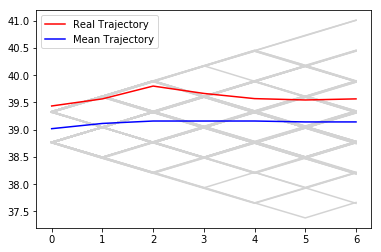

In [43]:
path = './images/'
for date_id,date in enumerate(start_day):
    for stock_id,stock in enumerate(stock_sample):
        fig, ax = plt.subplots( nrows=1, ncols=1 )  # create figure & 1 axis
        for i in range(n_simuls):
            ax.plot(trajectories[date_id,stock_id,i,:], color="LightGrey")
        ax.plot(real_trajectories[date_id,stock_id,:], color="Red", label="Real Trajectory")
        ax.plot(mean_trajectories[date_id,stock_id,:], color = "Blue", label="Mean Trajectory")
        ax.legend()
        figname = path + 'day'+ str(date_id) + '_stock' + str(stock_id) + '.png'
        fig.savefig(figname, bbox_inches='tight')   # save the figure to file
        plt.close(fig)

